In [1]:
import tensorflow as tf, albumentations as A
import numpy as np
import os, shutil, random, cv2
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time, copy

%matplotlib inline
cudnn.benchmark = True
SEED = 0
batch_size = 64

def seed_everything(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    torch.manual_seed(seed)

seed_everything()

root_train_real = 'Sources\Train\Real'
root_train_fake = 'Sources\Train\Deepfake'
root_test_real = 'Sources\Test\Real'
root_test_fake = 'Sources\Test\Deepfake'
train_number_of_images = 10000
test_number_of_images = 6000
ratio = 0.5

In [2]:
class Dataset:
    def __init__(self, real_root, fake_root, NO_Images, ratio=ratio):
        self.state = seed_everything()
        self.real_root = real_root
        self.fake_root = fake_root
        self.NO_Images = NO_Images
        self.ratio = ratio
        self.files_real = []
        self.files_fake = []
    
    def create_files_from_directories(self, ip):
        root_path = None
        tot_files = []
        if ip == 'real':
            root_path = self.real_root
        elif ip == 'fake':
            root_path = self.fake_root
        else:
            raise ValueError("Either: 'real' or 'fake' ip must be specified")
        for dir in os.listdir(root_path):
            path = os.path.join(root_path, dir)
            files_in_path = os.listdir(path)
            files_in_path = [path + '\\' + file_in_path for file_in_path in files_in_path]
            tot_files = tot_files + files_in_path
        return tot_files
    
    def set_files(self):
        self.files_real = self.create_files_from_directories(ip='real')
        self.files_fake = self.create_files_from_directories(ip='fake')

    def pick_random_images(self, ip):
        self.state
        file = []
        if ip == 'real':
            file = self.files_real
        elif ip == 'fake':
            file = self.files_fake
        else:
            raise ValueError("Either: 'real' or 'fake' ip must be specified")
        sampling = int(self.NO_Images*self.ratio)
        if sampling > len(file):
            sampling = len(file)
        return random.sample(file, sampling)
    
    def randomize(self):
        self.set_files()
        self.files_real_randomized = self.pick_random_images('real')
        self.files_fake_randomized = self.pick_random_images('fake')
        
    def get_files(self):
        self.randomize()
        return self.files_real_randomized, self.files_fake_randomized

    def combine_real_fake(self):
        self.randomize()
        combined = self.files_real_randomized + self.files_fake_randomized
        self.X = random.sample(combined, len(combined))

    def create_folders(self, folder, i_p=['real', 'fake']):
        self.randomize()
        for ip in i_p:
            os.makedirs(folder + "\\" + ip, exist_ok=True)
        for file in self.files_real_randomized:
            shutil.copy(file, folder + "\\" + i_p[0])
        print("Done copying Real files")
        for file in self.files_fake_randomized:
            shutil.copy(file, folder + "\\" + i_p[1])
        print("Done copying Fake files")

    def Create_Target(self):
        self.combine_real_fake()
        self.y = []
        for x in self.X:
            self.y.append(x.split("\\")[4][0])
    
    #TO DO: make X as image
    def list2image(self):
        # self.X_images = map(Image.open, self.X) -> OSError: [Errno 24] Too many open files:
        self.X_images = []
        for filename in self.X:
            im = Image.open(filename)
            img = im.copy()
            img = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2RGB)
            transform_resize = A.Resize(height=160, width=160, interpolation=1)
            transformed_res = transform_resize(image=img)
            img = transformed_res['image']
            img = img/255
            self.X_images.append((img))
            im.close()
      
    def list2tensor(self):
        self.X = np.array(self.X, dtype='object')
        self.y = np.array(self.y, dtype=np.int8)
        # self.X_images = np.array(self.X_images, dtype='float32')
        # self.X_tensor = torch.tensor(self.X_images)
        # self.y_tensor = torch.tensor(self.y)

    def get_Dataset(self):
        self.Create_Target()
        # self.list2image()
        self.list2tensor()
        # return self.X_tensor, self.y_tensor
        return self.X, self.y

def create_X_y(root_real, root_fake, number_of_images):
    seed_everything()
    data = Dataset(root_real, root_fake, number_of_images)
    return data.get_Dataset()

def copy_images(folder, root_real, root_fake, number_of_images):
    data = Dataset(root_real, root_fake, number_of_images)
    data.create_folders(folder)

Train = "Train"
Test = "Test"


# os.makedirs(Train, exist_ok=True)
# os.makedirs(Test, exist_ok=True)
# copy_images(Train, root_train_real, root_train_fake, train_number_of_images)
# copy_images(Test, root_test_real, root_test_fake, test_number_of_images)


X_train, y_train = create_X_y(root_train_real, root_train_fake, train_number_of_images)
X_test, y_test = create_X_y(root_test_real, root_test_fake, train_number_of_images)


# train = Dataset(root_train_real, root_train_fake, train_number_of_images)
# test = Dataset(root_test_real, root_test_fake, train_number_of_images)
# X_train, y_train = train.get_Dataset()
# X_test, y_test = test.get_Dataset()


# TENSORFLOW

In [7]:
import tensorflow as tf
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(Train,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

test_dataset = tf.keras.utils.image_dataset_from_directory(Test,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

class_names = train_dataset.class_names
train_dataset = train_dataset.shuffle(train_size)
test_dataset = test_dataset.shuffle(test_size)


train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 10000 files belonging to 2 classes.
Found 5996 files belonging to 2 classes.


In [18]:
preprocess_input = tf.keras.applications.vgg19.preprocess_input

In [19]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.VGG19(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

# image_batch, label_batch = next(iter(train_dataset))
# feature_batch = base_model(image_batch)
# print(feature_batch.shape)
for layer in base_model.layers:
    layer.trainable = False

In [20]:
x = preprocess_input(base_model.input)
x = tf.keras.layers.Flatten()(base_model(x, training=False))
prediction = tf.keras.layers.Dense(2, activation= 'softmax')(x)
model = tf.keras.models.Model(inputs=base_model.input, outputs=prediction)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 160, 160, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 vgg19 (Functional)          (None, 5, 5, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 12800)             0         
                                                                 
 dense_1 (Dense)             (None, 2)                 2560

In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [22]:
history = model.fit(train_dataset,
                    epochs=15,
                    validation_data=test_dataset,)  

Epoch 1/15
157/157 [==============================] - 44s 225ms/step - loss: 4.9663 - accuracy: 0.6401 - val_loss: 3.8166 - val_accuracy: 0.6963
Epoch 2/15
157/157 [==============================] - 36s 213ms/step - loss: 2.4447 - accuracy: 0.7742 - val_loss: 4.0473 - val_accuracy: 0.6945
Epoch 3/15
157/157 [==============================] - 36s 212ms/step - loss: 1.7940 - accuracy: 0.8163 - val_loss: 4.6284 - val_accuracy: 0.6996
Epoch 4/15
157/157 [==============================] - 36s 212ms/step - loss: 1.4496 - accuracy: 0.8503 - val_loss: 5.7591 - val_accuracy: 0.6930
Epoch 5/15
157/157 [==============================] - 36s 213ms/step - loss: 1.1974 - accuracy: 0.8701 - val_loss: 5.1695 - val_accuracy: 0.7131
Epoch 6/15
 17/157 [==>...........................] - ETA: 17s - loss: 0.7918 - accuracy: 0.9136

KeyboardInterrupt: 

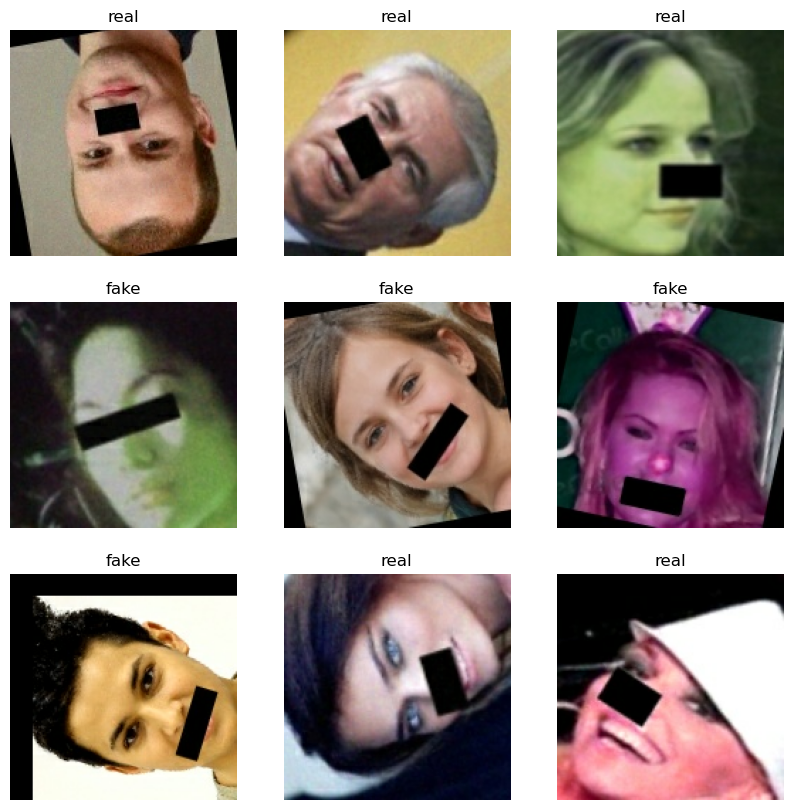

In [28]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# PYTORCH

In [3]:
from torchvision import models
from torch.utils.data import Dataset, DataLoader
import glob


class CustomDataSet(Dataset):
    def __init__(self, root):
        self.root = root + '\\'
        self.data = self.create_data()
        self.class_map = {"real" : 0, "fake": 1}
        self.image_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((160, 160)),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])


    def create_data(self):
        data = []
        file_list = glob.glob(self.root +'\\' + "*")
        for class_path in file_list:
            class_name = class_path.split("\\")[-1]
            for img_path in glob.glob(class_path + "/*.jpg"):
                data.append([img_path, class_name])
        return np.array(data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_loc, class_name = self.data[idx]
        image = Image.open(img_loc)
        class_id = self.class_map[class_name]
        if self.image_transform:
            tensor_image = self.image_transform(image)
        return tensor_image, class_id

def create_dataloader(folder, batch_size=64):
    seed_everything()
    dataset = CustomDataSet(folder)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader, dataset

train_dataloader, train_dataset = create_dataloader(Train)
test_dataloader, test_dataset= create_dataloader(Test)
dataset_sizes = {'Train': len(train_dataloader.dataset),
                 'Test': len(test_dataloader.dataset)}
dataloader_dict = {'Train': train_dataloader, 'Test': test_dataloader}
print(dataset_sizes)

{'Train': 10000, 'Test': 5996}


In [ ]:
# WRITE NUMBER OF STEPS

In [4]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

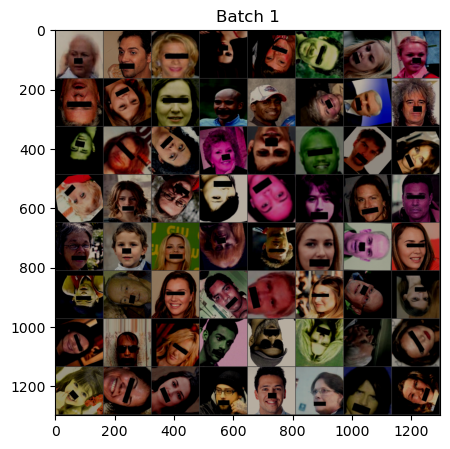

In [4]:
def imshow(inp, title = None):
  inp = inp.numpy().transpose((1,2,0))
  mean = [0.485, 0.456, 0.406]
  std = [0.229, 0.224, 0.225]
  inp = std + inp * mean
  inp = np.clip(inp,0,1)
  plt.figure(figsize = (14,5))
  plt.imshow(inp);
  if title is not None:
    plt.title(title);
#show sample batch of images
images, labels = next(iter(dataloader_dict['Train']))
out = torchvision.utils.make_grid(images)

imshow(out, 'Batch 1')

In [8]:
from collections import OrderedDict

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Number of classes in the dataset
num_classes = 2
feature_extract = True

def get_model():
    model = models.vgg19_bn(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False #Freezing all the layers and changing only the below layers
    Classifier = nn.Sequential(OrderedDict([
                            ('fc1', nn.Linear(25088, 4096)),
                            ('relu', nn.ReLU()),
                            ('dropout', nn.Dropout(p=0.5)),
                            ('fc2', nn.Linear(4096, num_classes)),
                            ]))
    model.classifier = Classifier
    # model.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes, bias=True)
    model.to(device)
    criterion_conv = nn.CrossEntropyLoss()
    optimizer_conv = optim.Adam(model.classifier.parameters(), lr = 0.001)
    exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
    return model.to(device), criterion_conv, optimizer_conv, exp_lr_scheduler

model, loss_fn, optimizer, exp_lr_scheduler = get_model()
params_to_update = model.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

c:\Users\abdel\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\abdel\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Params to learn:
	 classifier.fc1.weight
	 classifier.fc1.bias
	 classifier.fc2.weight
	 classifier.fc2.bias


In [20]:
def get_model2():
    model = models.vgg19_bn(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False #Freezing all the layers and changing only the below layers
    # Classifier = nn.Sequential(OrderedDict([
    #                         ('fc1', nn.Linear(25088, 4096)),
    #                         ('relu', nn.ReLU()),
    #                         ('dropout', nn.Dropout(p=0.5)),
    #                         ('fc2', nn.Linear(4096, num_classes)),
    #                         ]))
    # model.classifier = Classifier
    model.classifier[6] = torch.nn.Linear(4096, 2)
    model.to(device)
    criterion_conv = nn.CrossEntropyLoss()
    optimizer_conv = optim.SGD(model.classifier.parameters(), lr = 0.001,  momentum=0.9)
    exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

    return model.to(device), criterion_conv, optimizer_conv, exp_lr_scheduler
    
model2, loss_fn2, optimizer2, exp_lr_scheduler2 = get_model2()
params_to_update = model2.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model2.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model2.named_parameters():
        if param.requires_grad == True:
            print("\t",name)



Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [11]:
import gc
def report_gpu():
   gc.collect()
   torch.cuda.empty_cache()
report_gpu()

In [20]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs = 25):
    since = time.time()
    test_acc_history = []
    train_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
      start_epoch = time.time()
      print('Epoch {}/{}'.format(epoch, num_epochs - 1))
      print('=' *20)
      for phase in ['Train', 'Test']:
        if phase == 'Train':
          model.train()
        else:
          model.eval()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in dataloaders[phase]:
          inputs = inputs.to(device)
          labels = labels.to(device)
          optimizer.zero_grad()
          with torch.set_grad_enabled(phase == 'Train'):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            if phase == 'Train':
              loss.backward()
              optimizer.step()
          running_loss += loss.item() * inputs.size(0)
          running_corrects += torch.sum(preds == labels.data)
        if phase == 'Train':
          scheduler.step()
        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
        if phase == 'Test' and epoch_acc > best_acc:
          best_acc = epoch_acc
          best_model_wts = copy.deepcopy(model.state_dict())
        if phase =='Test':
          test_acc_history.append(epoch_acc)
        else:
          train_acc_history.append(epoch_acc)
      print('Epoch completed in {:.0f}m {:.0f}s'.format((time.time()-start_epoch) // 60, (time.time()-start_epoch) % 60))
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Validation Accuracy: {}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model, test_acc_history
trained_model, history = train_model(model, dataloader_dict, loss_fn, optimizer, exp_lr_scheduler)


Epoch 0/24
Train Loss: 0.9517 Acc: 0.6510
Test Loss: 0.5257 Acc: 0.7353
Epoch completed in 1m 17s
Epoch 1/24
Train Loss: 0.5249 Acc: 0.7386
Test Loss: 0.5286 Acc: 0.7320
Epoch completed in 1m 20s
Epoch 2/24


RuntimeError: CUDA out of memory. Tried to allocate 400.00 MiB (GPU 0; 6.00 GiB total capacity; 3.55 GiB already allocated; 0 bytes free; 4.96 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## PYTORCH PRETRAINED MODEL

In [12]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    test_acc_history, test_loss_history = [], []
    train_acc_history, train_loss_history = [], []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        start_epoch = time.time()
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('--' * 50)
        for phase in ['Train', 'Test']:
            if phase == 'Train':
                model.train()
            else:
                model.eval() 
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'Train':
                scheduler.step()
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            if phase == 'Test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'Test':
                test_acc_history.append(epoch_acc)
                test_loss_history.append(epoch_loss)
            else:
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
        print('Epoch completed in {:.0f}m {:.0f}s'.format((time.time()-start_epoch) // 60, (time.time()-start_epoch) % 60))

        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Test Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model, (train_acc_history, test_acc_history), (train_loss_history, test_loss_history)

model_ft, acc_hist, loss_hist = train_model(model, dataloader_dict, loss_fn, optimizer, exp_lr_scheduler)

Epoch 1/25
----------------------------------------------------------------------------------------------------
Train Loss: 0.3953 Acc: 0.8182
Test Loss: 0.4984 Acc: 0.7692
Epoch completed in 2m 3s

Epoch 2/25
----------------------------------------------------------------------------------------------------
Train Loss: 0.3429 Acc: 0.8436
Test Loss: 0.5041 Acc: 0.7703
Epoch completed in 1m 15s

Epoch 3/25
----------------------------------------------------------------------------------------------------
Train Loss: 0.2725 Acc: 0.8864
Test Loss: 0.5241 Acc: 0.7812
Epoch completed in 1m 15s

Epoch 4/25
----------------------------------------------------------------------------------------------------
Train Loss: 0.2279 Acc: 0.9055
Test Loss: 0.5189 Acc: 0.7847
Epoch completed in 1m 15s

Epoch 5/25
----------------------------------------------------------------------------------------------------
Train Loss: 0.1442 Acc: 0.9504
Test Loss: 0.5222 Acc: 0.7922
Epoch completed in 1m 15s

E

In [46]:
  def evaluate(model, test_loader):
    with torch.no_grad():
        predictions = []
        values = []
        for input, label in test_loader:
            input, label = input.to(device).float(), label.to(device).long()
            model.eval() # evaluation mode e.g. stop batchnorm, dropout
            yhat = model(input)
            _, y_pred = torch.max(yhat, 1)
            predictions.append(y_pred.cpu().detach().numpy()) #back to cpu to use numpy
            values.append(label.cpu().detach().numpy())

    return predictions, values

y_hat, y_true = evaluate(model, dataloader_dict['Test'])

In [54]:
y_true

[array([1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
        0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0],
       dtype=int64),
 array([0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0],
       dtype=int64),
 array([1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1,
        1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1],
       dtype=int64),
 array([0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0,
        0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=int64),
 array([0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1

In [57]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
correct_flat = [item for sublist in y_true for item in sublist]
predicted_flat = [item for sublist in y_hat for item in sublist]
f1=f1_score(correct_flat, predicted_flat)
print(f1)
print(confusion_matrix(correct_flat, predicted_flat))

0.7987907289217333
[[2420  580]
 [ 618 2378]]
